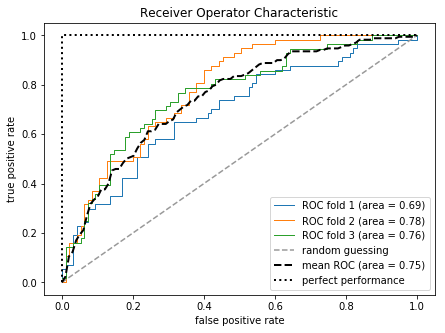

ROC AUC: 0.662
Accuracy: 0.711


"\nprescorer = make_scorer(score_func=precision_score,\n\t\t\t\t\t\tpos_label=1,\n\t\t\t\t\t\tgreater_is_better=True,\n\t\t\t\t\t\tavarage='micro')\n"

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)
from sklearn.preprocessing import LabelEncoder
# 30個の特徴量をXに格納する
X = df.loc[:, 2:].values
# M(malignant)とB(benign)の列をyに格納する
y = df.loc[:, 1].values
le = LabelEncoder()
# M,Bを数値に変換する
y = le.fit_transform(y)

from sklearn.cross_validation import StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.20, random_state=1)

from sklearn.metrics import roc_curve, auc
from scipy import interp
# スケーリング、主成分分析、ロジスティック回帰を指定して、
# Pipelineクラスをインスタンス化
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(penalty='l2',
                                               random_state=0,
                                               C=100.0))])
# 2つの特徴量を抽出
X_train2 = X_train[:, [4, 14]]
# 深化k分割交差検証イテレータを表すStratifiedKFoldクラスをインスタンス化
cv = StratifiedKFold(y_train, n_folds=3, random_state=1)
fig = plt.figure(figsize=(7, 5))
mean_tpr = 0.0
# ０から１までの間で１００個の要素を生成
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
for i, (train, test) in enumerate(cv):
    # predict_probaメソッドで確率を予測、fitメソッドでモデルに適合させる
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])
    # roc_curve関数でROC曲線の性能を計算してプロット
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1], pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)  # FPR（X軸）とTPR（Y軸）を線形補間
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))

# 当て推量をプロット
plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='random guessing')
# FPR、TPR、ROC AUCそれぞれの平均を計算してプロット
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
# 完全に予測が正解した時のROC曲線をプロット
plt.plot([0, 0, 1],
         [0, 1, 1],
         lw=2,
         linestyle=':',
         color='black',
         label='perfect performance')
# グラフの各項目を推定
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc="lower right")
plt.show()

# 予測値のAUCと正解率を計算して出力
pipe_lr = pipe_lr.fit(X_train2, y_train)
y_pred2 = pipe_lr.predict(X_test[:, [4, 14]])
from sklearn.metrics import roc_auc_score, accuracy_score
print('ROC AUC: %.3f' % roc_auc_score(y_true=y_test, y_score=y_pred2))
print('Accuracy: %.3f' % accuracy_score(y_true=y_test, y_pred=y_pred2))

"""
prescorer = make_scorer(score_func=precision_score,
						pos_label=1,
						greater_is_better=True,
						avarage='micro')
"""